In [1]:
from preprocessing import Preprocessor
from training import Trainer, Metrics
import torch.nn as nn
import torch.optim as optim
from models.first_CNN import firstCNN

In [2]:
years = [str(y) for y in range(2006, 2015)]
classes = ["detritus", "Leptocylindrus", "Chaetoceros", "Rhizosolenia", "Guinardia_delicatula", "Cerataulina", 
           "Cylindrotheca", "Skeletonema", "Dactyliosolen", "Thalassiosira", "Dinobryon", "Corethron", "Thalassionema", 
           "Ditylum", "pennate", "Prorocentrum", "Pseudonitzschia", "Tintinnid", "Guinardia_striata", "Phaeocystis"]
pp = Preprocessor(years, include_classes=classes, train_eg_per_class=500)


In [3]:
pp.create_datasets([0.6,0.2,0.2])

In [6]:
trainLoader = pp.get_loaders('train', 128)
validLoader = pp.get_loaders('validation', 128)

In [7]:
trainer = Trainer(epochs = 10, loss_fn = nn.MSELoss, optimizer = optim.SGD, lr = 0.01, momentum = 0.9, useCuda=True)

In [8]:
model = firstCNN()

In [9]:
#trainer.train(model, trainLoader, validLoader)

# - or -

model = trainer.load_full_model(model, "./models/firstCNN-2.0.pth")

In [10]:
testLoader = pp.get_loaders('test', 128)
pred, target = trainer.test(model, testLoader)

label: Tintinnid . encoded: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0.])label: Cerataulina . encoded: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

label: Skeletonema . encoded: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0.])
label: Dinobryon . encoded: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
label: Prorocentrum . encoded: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.])
label: Dactyliosolen . encoded: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
label: Rhizosolenia . encoded: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.])
label: Guinardia_delicatula . encoded: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 

/userhome/30/smaghani/URFP/models/first_CNN.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


label: Skeletonema . encoded: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0.])
label: pennate . encoded: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1.])label: Leptocylindrus . encoded: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

label: Prorocentrum . encoded: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.])label: Cylindrotheca . encoded: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
label: Ditylum . encoded: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])label: Dactyliosolen . encoded: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])


label: Leptocylindrus . encoded: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.

0.042
0.042
0.042


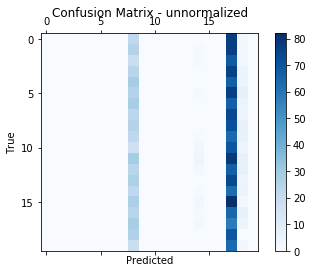

In [11]:
met = Metrics(target, pred)
met.accuracy()
met.recall()
met.f_score()
met.plot_CM(normalize=False)

In [19]:
import numpy as np
random_idx = np.random.choice(list(range(len(target))), size = 100, replace = False)
target_ = np.array(target.cpu())[random_idx]
pred_ = np.array(pred.cpu())[random_idx]

In [20]:
target_

array([14, 12, 15, 14, 17,  5, 16,  6,  9,  5,  8,  2,  9, 18, 18, 15,  6,
        7, 14, 15, 15,  3,  9,  3,  7, 11,  9, 15, 15, 16, 17, 16, 14, 14,
       11,  0, 11, 15,  9, 14, 12,  5,  0, 10, 11,  6,  9,  5, 11,  1,  3,
       11,  4, 10,  7, 13, 18, 10, 18, 17,  7,  3, 13,  8,  8, 11,  1, 10,
       16,  2,  1,  1,  5,  1, 12,  3, 14,  3, 13,  4,  3,  9, 17, 13, 12,
        4,  4,  4,  6,  8,  0, 11, 14, 19, 16,  9, 16, 13, 17, 12])

In [21]:
pred_

array([ 8, 17, 17, 17, 17, 17, 17, 17,  8, 17, 17, 17, 17, 17, 17, 17, 17,
       17,  8, 17, 17, 17,  8, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18,  8,
        8, 17, 14, 17, 17, 18, 17, 17,  8, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17,  8, 17, 17,  8,  8, 17, 17, 17,  8, 17, 17, 17,  8,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,  8, 17, 14, 17,  8,  8,
       17, 17, 17, 17, 17, 17,  8, 17,  8, 17, 17, 17,  8,  8,  8])